In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Image Rotation

# Generate a list of rotated images

In [3]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt

# angles = for k in range(15, 181, 15)
# angles = [15,30,45,60,75,90,105,120,135,150,165,180]
angle = 30

def rotate_images(images, angle):
    rotated_images = []
    for img in images:
        rotated_image = ndimage.rotate(img, angle, reshape=False)
        # rotated_image = ndimage.rotate(img, angle, reshape=True)
        rotated_images.append(rotated_image)
    return rotated_images

train_rotated_images = rotate_images(train_dataset.data, angle)
test_rotated_images = rotate_images(test_dataset.data, angle)

train_rotated_images = np.array(train_rotated_images)
test_rotated_images = np.array(test_rotated_images)
print("Train rotated images shape")
print(train_rotated_images.shape)

print("Test rotated images shape")
print(test_rotated_images.shape)



Train rotated images shape
(50000, 32, 32, 3)
Test rotated images shape
(10000, 32, 32, 3)


# Visualizing generated rotated images

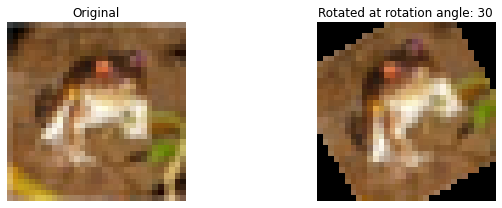

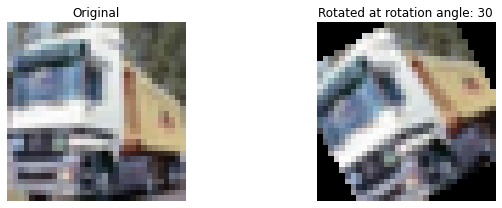

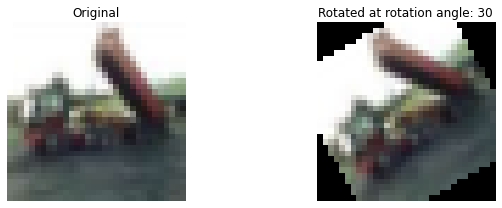

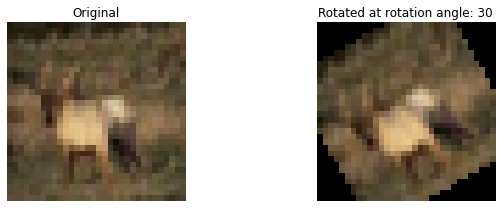

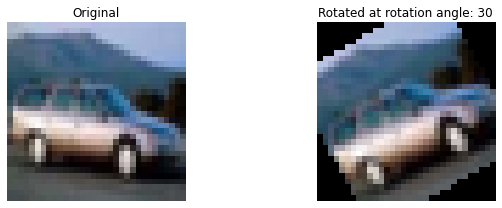

In [4]:
i=0
for rotated_image in train_rotated_images:
    fig = plt.figure(figsize=(10, 3))
    ax1,ax2 = fig.subplots(1,2)
    ax1.imshow(train_dataset.data[i], cmap='gray')
    ax1.set_axis_off()
    ax1.set_title("Original")
    ax2.imshow(rotated_image, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title("Rotated at rotation angle: "+str(angle))
    fig.set_tight_layout(True)
    plt.show()
    i +=1
    
    if i==5:
        break
    

# Combining original and rotated images

In [5]:
original_image_labels = np.zeros(len(train_dataset.data))
rotated_image_labels = np.ones(len(train_rotated_images))

test_original_image_labels = np.zeros(len(test_dataset.data))
test_rotated_image_labels = np.ones(len(test_rotated_images))

train_original_and_rotated_images = np.concatenate((train_dataset.data, train_rotated_images), axis=0)
train_rotation_labels = np.concatenate((original_image_labels, rotated_image_labels), axis=None)
train_image_labels = np.concatenate((train_dataset.targets, train_dataset.targets), axis=None)

test_original_and_rotated_images = np.concatenate((test_dataset.data, test_rotated_images), axis=0)
test_rotation_labels = np.concatenate((test_original_image_labels, test_rotated_image_labels), axis=None)


print("Combined rotated and original images shape")
print(train_original_and_rotated_images.shape)


Combined rotated and original images shape
(100000, 32, 32, 3)


# Extract image features

In [6]:
from image_feature_extractor import Img2Vec

img2vec = Img2Vec()

Z = img2vec.get_vec(train_original_and_rotated_images)

Z_test = img2vec.get_vec(test_original_and_rotated_images)

Z_test_original = img2vec.get_vec(test_dataset.data)

Z_test_rotated = img2vec.get_vec(test_rotated_images)

# vec.shape
print("Shape of extracted features for combined rotated and original images")
print(Z.shape)

print("Shape of extracted features for original test images")
print(Z_test_original.shape)

print("Shape of extracted features for rotated test images")
print(Z_test_rotated.shape)


Shape of extracted features for combined rotated and original images
(100000, 512)
Shape of extracted features for original test images
(10000, 512)
Shape of extracted features for rotated test images
(10000, 512)


# Obtaining rotation prediction coefficients

In [7]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, train_rotation_labels)

rotation_coefficients = lr_model.coef_.reshape(-1,1)
rotation_coefficients = rotation_coefficients / np.linalg.norm(rotation_coefficients)

# print("Printing some of rotation coefficients")
# print(rotation_coefficients[:5,:])
# print()
print("Rotation coefficients shape")
print(rotation_coefficients.shape)

print('Rotation prediction accuracy on training data: ', lr_model.score(Z, train_rotation_labels))

print('Rotation prediction accuracy on test data-rotated and original combined: ', lr_model.score(Z_test, test_rotation_labels))

    


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Rotation coefficients shape
(512, 1)
Rotation prediction accuracy on training data:  0.99533
Rotation prediction accuracy on test data-rotated and original combined:  0.99405


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [8]:
# Trained on original extracted image features Z, tested on rotated extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


targets_train = np.array(test_dataset.targets)
targets_test = np.array(test_dataset.targets)


logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_test_original, targets_train)

print('LR Accuracy within training data - Z original features: ',logistic_regression_model.score(Z_test_original, targets_train))
print('LR Accuracy on test data - Z rotated features: ', logistic_regression_model.score(Z_test_rotated, targets_test))



LR Accuracy within training data - Z original features:  0.7486
LR Accuracy on test data - Z rotated features:  0.3359


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Find L, get F features, plot histograms and perform predictions





Results for lamda  100000

Printing eigenvalues
(512,)
[-4.12240363e-10  1.13535706e+02  9.73683863e+02  1.38666822e+03
  1.52204443e+03  1.56044557e+03  1.58281380e+03  1.69466997e+03
  1.77667004e+03  1.92810785e+03  1.98910112e+03  2.03288317e+03
  2.08005686e+03  2.14189408e+03  2.30503908e+03  2.41434932e+03
  2.52329954e+03  2.58915521e+03  2.63139412e+03  2.78849582e+03
  2.83376100e+03  2.90648689e+03  2.92625112e+03  2.97177328e+03
  3.04886463e+03  3.10657572e+03  3.15223871e+03  3.16507261e+03
  3.19023815e+03  3.23442139e+03  3.27227669e+03  3.34196811e+03
  3.39379406e+03  3.39912444e+03  3.43919621e+03  3.52456912e+03
  3.55182257e+03  3.57429646e+03  3.61683241e+03  3.66688190e+03
  3.70501870e+03  3.71681285e+03  3.74229755e+03  3.78975937e+03
  3.81152996e+03  3.85006988e+03  3.89677291e+03  3.92703932e+03
  4.00505353e+03  4.00681802e+03  4.08516361e+03  4.09400007e+03
  4.16021862e+03  4.20338716e+03  4.23019451e+03  4.27505387e+03
  4.29793391e+03  4.32171759e+0

(512, 512)

array([[ 5.30513660e-02, -1.97902367e-03,  9.83056237e-05, ...,
        -2.77533212e-02,  2.60267394e-02,  5.11240667e-02],
       [ 9.86060432e-03, -5.11521598e-04,  7.22304709e-04, ...,
        -2.29537282e-02,  2.21968311e-02,  1.03464822e-01],
       [-2.56525487e-02,  9.65771334e-05, -2.79618422e-03, ...,
         9.85765729e-02,  1.11260930e-01,  1.08461597e-01],
       ...,
       [ 7.37840130e-03, -2.03249583e-04, -1.25559642e-04, ...,
        -1.83071559e-02, -1.15387157e-02,  3.09492315e-02],
       [-4.95922806e-02,  5.44258030e-04, -1.67662157e-03, ...,
        -2.94748432e-02,  5.29093886e-02,  3.66673313e-02],
       [ 1.84949439e-02, -1.39437172e-02,  5.52499776e-03, ...,
         5.47117911e-03, -2.29337204e-02,  9.02485916e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[   0.          113.53570607  973.68386327 1386.66822494 1522.04443366
 1560.44557347 1582.81379903 1694.66997431 1776.67004306 1928.1078463
 1989.10111797 2032.88317456 2080.05685679 2141.89407933 2305.03907573
 2414.3493173  2523.29954456 2589.15520923 2631.39412036 2788.49582336
 2833.76100163 2906.48688592 2926.25112455 2971.7732809  3048.86462901]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 113.53570607  973.68386327 1386.66822494 1522.04443366 1560.44557347
 1582.81379903 1694.66997431 1776.67004306 1928.1078463  1989.10111797
 2032.88317456 2080.05685679 2141.89407933 2305.03907573 2414.3493173
 2523.29954456 2589.15520923 2631.39412036 2788.49582336 2833.76100163
 2906.48688592 2926.25112455 2971.7732809  3048.86462901]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,0.001205,0.011345,0.043879,0.002769,0.062673,0.213526,0.060213,0.025372,0.136942,...,0.020083,0.071036,0.141505,0.402696,0.158435,0.276058,0.054068,0.303522,0.061427,0.047020
1,2.435494,0.015381,0.807916,0.171112,0.043540,0.228113,0.184805,0.197458,0.198982,0.192582,...,0.274189,0.308260,0.216083,0.004434,0.212456,0.401190,0.373308,0.180328,0.197489,0.231327
2,3.148465,0.013777,0.004360,0.101988,0.284126,0.007379,0.009958,0.257834,0.011024,0.174276,...,0.096497,0.489465,0.070290,0.183660,0.222572,0.178628,0.173063,0.262103,0.124395,0.131173
3,3.554349,0.002414,0.027814,0.078695,0.079132,0.065876,0.058335,0.287415,0.019425,0.017088,...,0.036434,0.074289,0.502579,0.396033,0.259390,0.038900,0.197303,0.322156,0.091632,0.114308
4,2.496241,0.020911,0.047478,0.142521,0.024462,0.018559,0.079109,0.227914,0.119280,0.010967,...,0.234149,0.108484,0.038820,0.038767,0.018984,0.109553,0.000441,0.082323,0.157299,0.000671


Histogram for F Test feature  0


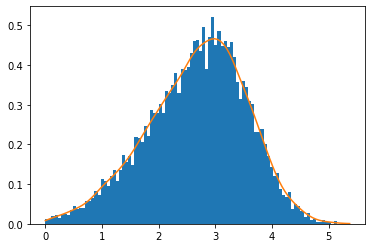

Histogram for F Test feature  1


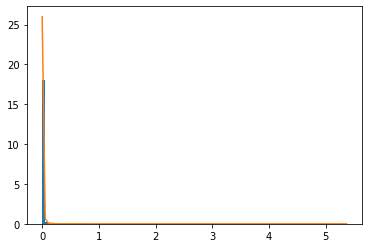

Histogram for F Test feature  2


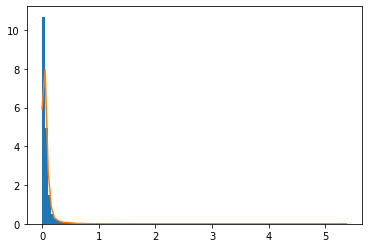

Histogram for F Test feature  3


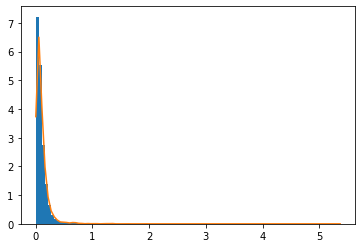

Histogram for F Test feature  4


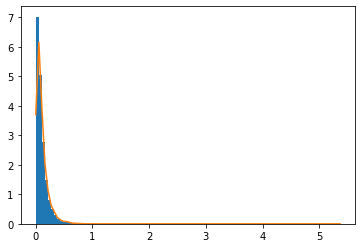

Histogram for F Test feature  5


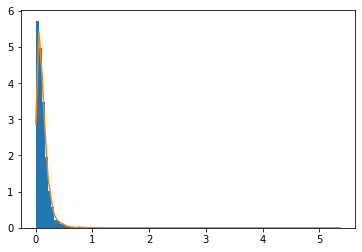

Histogram for F Test feature  6


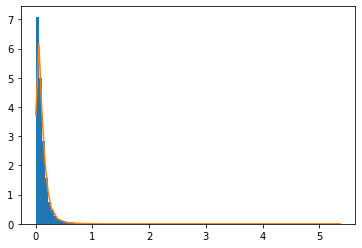

Histogram for F Test feature  7


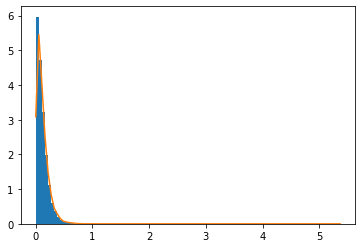

Histogram for F Test feature  8


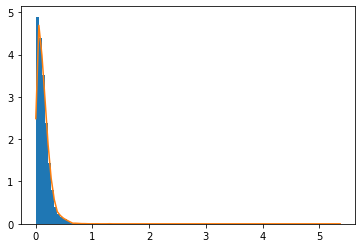

Histogram for F Test feature  9


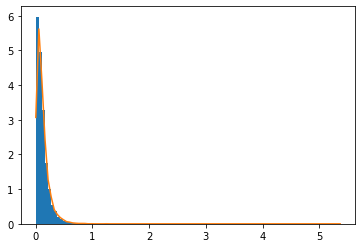

Histogram for F Test feature  10


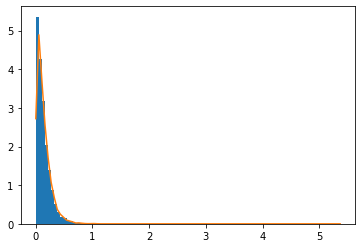

Histogram for F Test feature  11


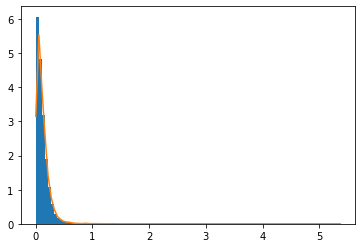

Histogram for F Test feature  12


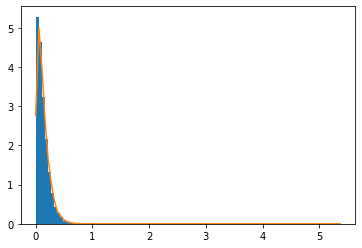

Histogram for F Test feature  13


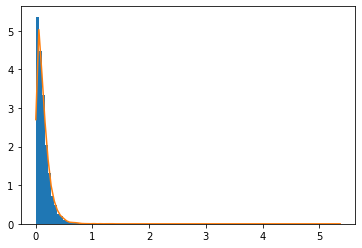

Histogram for F Test feature  14


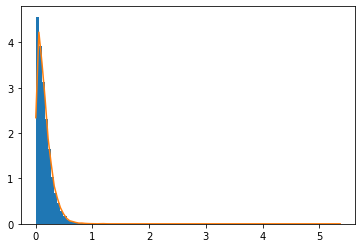

Histogram for F Test feature  15


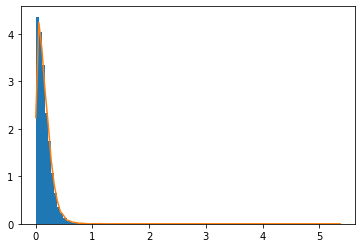

Histogram for F Test feature  16


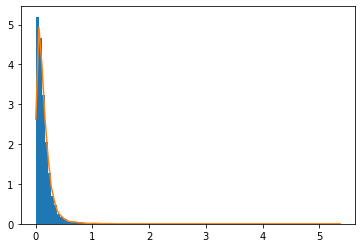

Histogram for F Test feature  17


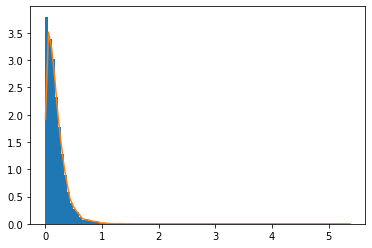

Histogram for F Test feature  18


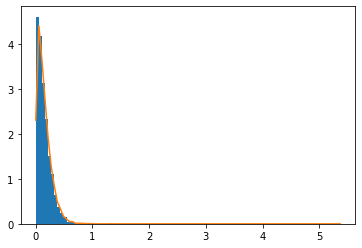

Histogram for F Test feature  19


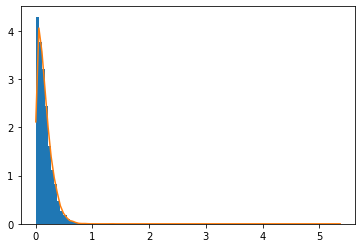

Histogram for F Test feature  20


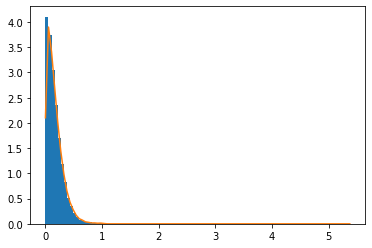

Histogram for F Test feature  21


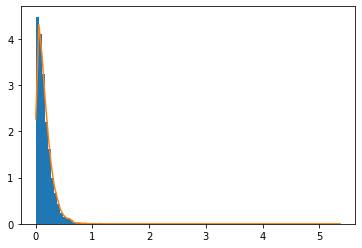

Histogram for F Test feature  22


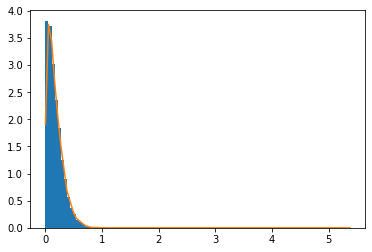

Histogram for F Test feature  23


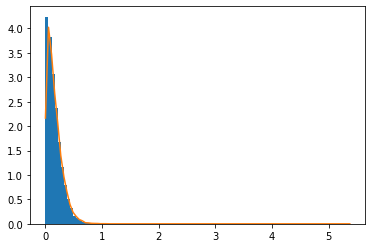

Histogram for F Test feature  24


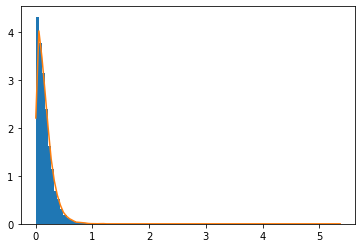

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.287
LR Accuracy on test data - All features:  0.1477
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not rotated:  0.2681
Logistic Regression Accuracy on test data - rotated:  0.1491
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not rotated:  0.2875
Logistic Regression Accuracy on test data - rotated:  0.1483
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2839
Logistic Regression Accuracy on test data - rotated:  0.1464
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2851
Logistic Regression Accuracy on test data - rotated:  0.1489
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2832
Logistic Regression Accuracy on test data - rotated:  0.1478
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2868
Logistic Regression Accuracy on test data - rotated:  0.1454
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2842
Logistic Regression Accuracy on test data - rotated:  0.1472
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2857
Logistic Regression Accuracy on test data - rotated:  0.1471
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.286
Logistic Regression Accuracy on test data - rotated:  0.1477
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1472
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2787
Logistic Regression Accuracy on test data - rotated:  0.1488
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2824
Logistic Regression Accuracy on test data - rotated:  0.1435
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2841
Logistic Regression Accuracy on test data - rotated:  0.1473
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2848
Logistic Regression Accuracy on test data - rotated:  0.146
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2687
Logistic Regression Accuracy on test data - rotated:  0.1414
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1465
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2854
Logistic Regression Accuracy on test data - rotated:  0.1462
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2821
Logistic Regression Accuracy on test data - rotated:  0.1437
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2824
Logistic Regression Accuracy on test data - rotated:  0.1462
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2856
Logistic Regression Accuracy on test data - rotated:  0.1472
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2832
Logistic Regression Accuracy on test data - rotated:  0.1478
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2854
Logistic Regression Accuracy on test data - rotated:  0.1468
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2837
Logistic Regression Accuracy on test data - rotated:  0.1433
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.288
Logistic Regression Accuracy on test data - rotated:  0.1473
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.2796
Logistic Regression Accuracy on test data - rotated:  0.1466




Results for lamda  0.1

Printing eigenvalues
(512,)
[-2.40918580e+02 -4.15233073e+01 -2.04225519e+01 -1.95682915e+01
 -1.47528048e+01 -1.25313375e+01 -1.14544114e+01 -8.38007134e+00
 -7.64043389e+00 -6.54955699e+00 -5.98919478e+00 -5.26650445e+00
 -4.82512794e+00 -4.58762129e+00 -4.38332353e+00 -3.81122171e+00
 -3.19782481e+00 -3.15213395e+00 -2.71799259e+00 -2.64586249e+00
 -2.49306230e+00 -2.44796928e+00 -2.27916191e+00 -2.09653505e+00
 -2.00727996e+00 -1.97022207e+00 -1.90026417e+00 -1.70447345e+00
 -1.70149564e+00 -1.52379513e+00 -1.44638485e+00 -1.39140829e+00
 -1.33612834e+00 -1.21973651e+00 -1.17852695e+00 -1.15790072e+00
 -1.09897179e+00 -1.06051365e+00 -1.02707613e+00 -9.88649953e-01
 -9.34596295e-01 -9.08152169e-01 -8.78381380e-01 -8.51972507e-01
 -8.10113172e-01 -8.01777839e-01 -7.69594083e-01 -7.58026984e-01
 -7.29686973e-01 -6.95405078e-

(512, 512)

array([[ 0.04495328, -0.03001938,  0.00089594, ...,  0.03149387,
        -0.05847688, -0.00053994],
       [ 0.12120991, -0.09608327,  0.15329504, ..., -0.01738531,
         0.17713141, -0.00795321],
       [ 0.07432376, -0.08511614,  0.08173733, ..., -0.08013087,
         0.04517856, -0.07726827],
       ...,
       [ 0.02511782,  0.02636693, -0.00713071, ..., -0.04450718,
        -0.03728492, -0.0516273 ],
       [ 0.01439132,  0.03252473, -0.02131417, ..., -0.08771671,
        -0.07790585, -0.09279867],
       [ 0.00595255,  0.00673815, -0.01180624, ..., -0.00267519,
         0.01956508, -0.01346197]])

Printing least k eigenvalues before removing the zero eigenvalue
[-240.91858015  -41.52330735  -20.42255186  -19.56829153  -14.75280478
  -12.5313375   -11.45441138   -8.38007134   -7.64043389   -6.54955699
   -5.98919478   -5.26650445   -4.82512794   -4.58762129   -4.38332353
   -3.81122171   -3.19782481   -3.15213395   -2.71799259   -2.64586249
   -2.4930623    -2.44796928   -2.27916191   -2.09653505   -2.00727996]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-240.91858015  -41.52330735  -20.42255186  -19.56829153  -14.75280478
  -12.5313375   -11.45441138   -8.38007134   -7.64043389   -6.54955699
   -5.98919478   -5.26650445   -4.82512794   -4.58762129   -4.38332353
   -3.81122171   -3.19782481   -3.15213395   -2.71799259   -2.64586249
   -2.4930623    -2.44796928   -2.27916191   -2.09653505]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,10.770502,7.869058,1.939438,5.633359,3.737961,2.150379,1.954185,2.031676,3.442938,...,0.024444,1.626186,0.214364,1.794206,0.900322,0.619497,0.715212,1.466246,0.169000,0.841163
1,2.435494,5.295459,3.307629,3.022553,5.168024,4.406291,7.045486,4.790044,8.390662,2.434579,...,1.092767,0.176192,3.529361,3.452595,0.705264,0.906415,1.304671,1.668059,2.158266,0.505925
2,3.148465,4.797788,2.691283,8.037981,6.443630,8.892746,6.556405,6.457501,0.677650,0.749284,...,0.040288,2.174695,0.075751,1.416913,0.388268,0.322281,2.168754,0.819737,1.605902,2.553377
3,3.554349,12.010774,10.972025,1.296820,6.210088,4.770672,4.463864,2.303010,3.403238,3.033904,...,0.609018,0.795211,1.609321,0.533741,3.126515,1.414778,0.769491,2.196843,0.135494,0.242512
4,2.496241,7.492244,4.185270,3.286347,2.105717,3.984753,1.964789,0.643950,0.037722,0.071086,...,5.080787,3.280422,0.878192,3.451643,2.908847,0.013581,1.064380,1.345746,1.369239,1.388906


Histogram for F Test feature  0


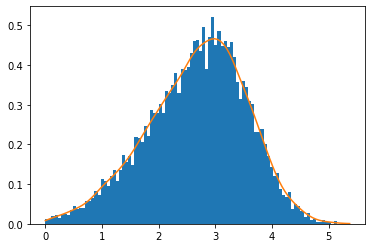

Histogram for F Test feature  1


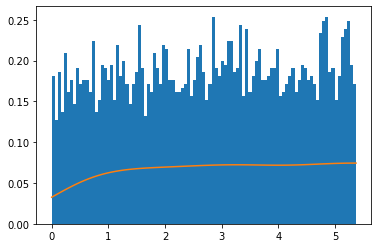

Histogram for F Test feature  2


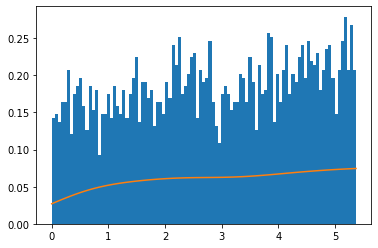

Histogram for F Test feature  3


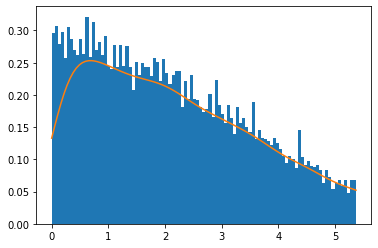

Histogram for F Test feature  4


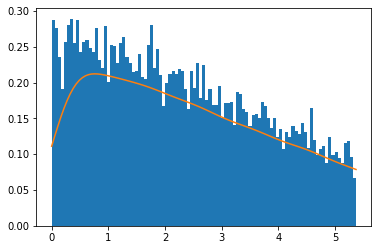

Histogram for F Test feature  5


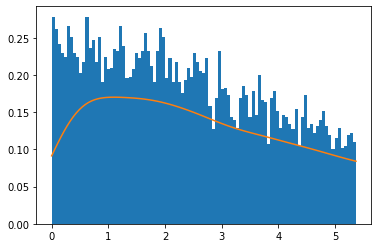

Histogram for F Test feature  6


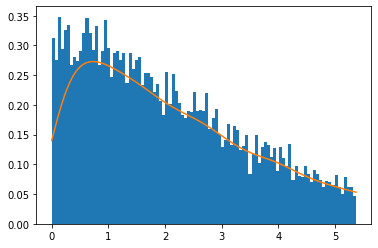

Histogram for F Test feature  7


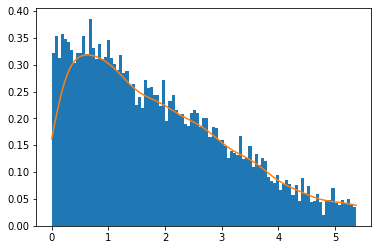

Histogram for F Test feature  8


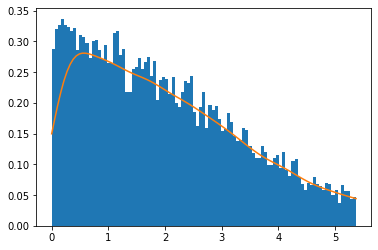

Histogram for F Test feature  9


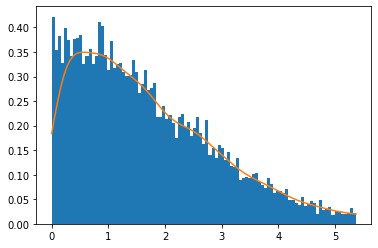

Histogram for F Test feature  10


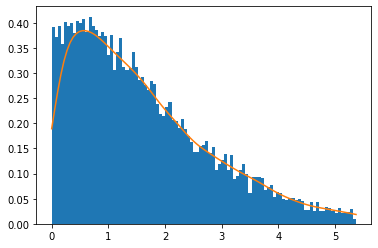

Histogram for F Test feature  11


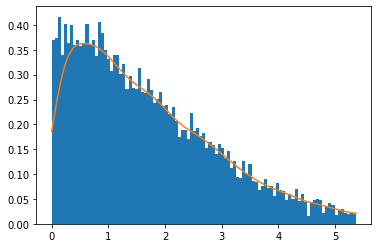

Histogram for F Test feature  12


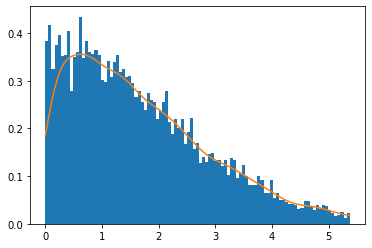

Histogram for F Test feature  13


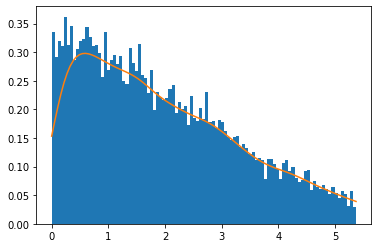

Histogram for F Test feature  14


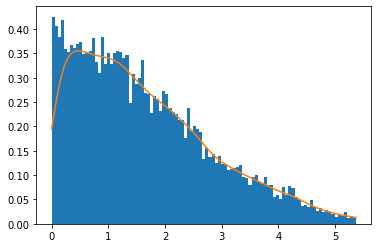

Histogram for F Test feature  15


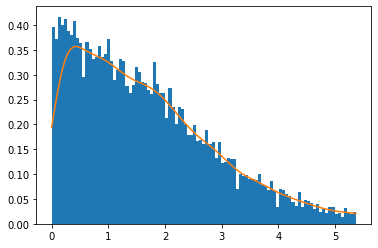

Histogram for F Test feature  16


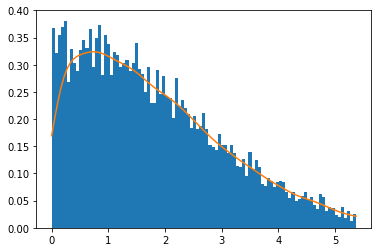

Histogram for F Test feature  17


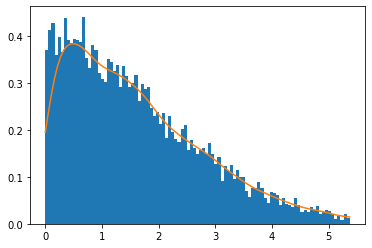

Histogram for F Test feature  18


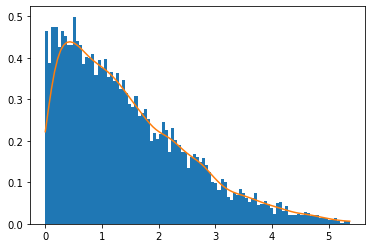

Histogram for F Test feature  19


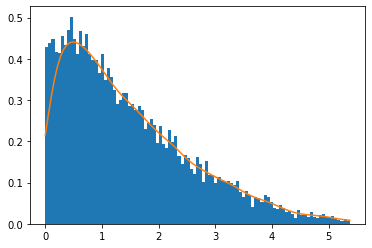

Histogram for F Test feature  20


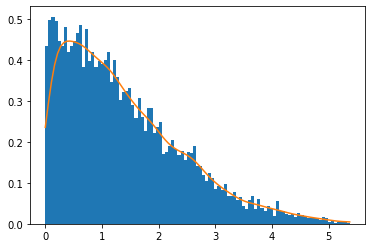

Histogram for F Test feature  21


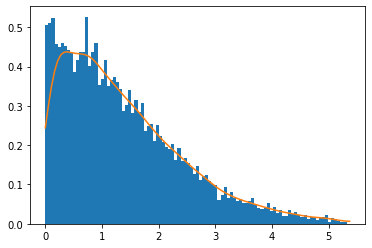

Histogram for F Test feature  22


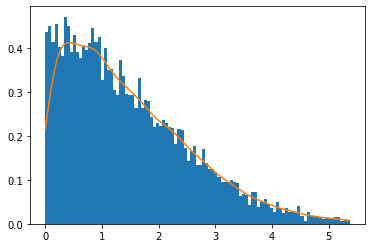

Histogram for F Test feature  23


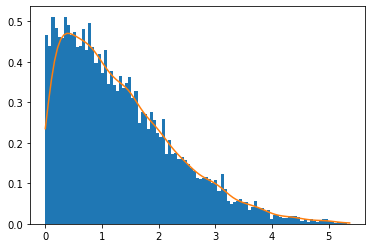

Histogram for F Test feature  24


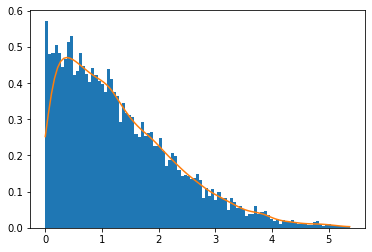

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5503
LR Accuracy on test data - All features:  0.3316
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5505
Logistic Regression Accuracy on test data - rotated:  0.3201
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5503
Logistic Regression Accuracy on test data - rotated:  0.3317
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5451
Logistic Regression Accuracy on test data - rotated:  0.3241
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5415
Logistic Regression Accuracy on test data - rotated:  0.287
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5438
Logistic Regression Accuracy on test data - rotated:  0.263
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5411
Logistic Regression Accuracy on test data - rotated:  0.3181
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5448
Logistic Regression Accuracy on test data - rotated:  0.2963
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5434
Logistic Regression Accuracy on test data - rotated:  0.323
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5393
Logistic Regression Accuracy on test data - rotated:  0.3257
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5397
Logistic Regression Accuracy on test data - rotated:  0.3255
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5412
Logistic Regression Accuracy on test data - rotated:  0.2938
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5445
Logistic Regression Accuracy on test data - rotated:  0.3152
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5472
Logistic Regression Accuracy on test data - rotated:  0.3158
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5394
Logistic Regression Accuracy on test data - rotated:  0.317
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5452
Logistic Regression Accuracy on test data - rotated:  0.3231
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5473
Logistic Regression Accuracy on test data - rotated:  0.3192
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5463
Logistic Regression Accuracy on test data - rotated:  0.3118
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5443
Logistic Regression Accuracy on test data - rotated:  0.3276
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5419
Logistic Regression Accuracy on test data - rotated:  0.301
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5467
Logistic Regression Accuracy on test data - rotated:  0.3277
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5474
Logistic Regression Accuracy on test data - rotated:  0.3342
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5453
Logistic Regression Accuracy on test data - rotated:  0.3372
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5443
Logistic Regression Accuracy on test data - rotated:  0.3281
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5492
Logistic Regression Accuracy on test data - rotated:  0.3171
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5452
Logistic Regression Accuracy on test data - rotated:  0.3232




Results for lamda  0.01

Printing eigenvalues
(512,)
[-2.60302321e+02 -4.27144739e+01 -2.10221317e+01 -2.01594079e+01
 -1.52196872e+01 -1.30776008e+01 -1.17874786e+01 -8.66157699e+00
 -7.89511008e+00 -6.73473371e+00 -6.23721526e+00 -5.46592347e+00
 -5.04105509e+00 -4.76530082e+00 -4.52617217e+00 -3.97391987e+00
 -3.30709799e+00 -3.27627326e+00 -2.80518625e+00 -2.77636211e+00
 -2.58625531e+00 -2.55547310e+00 -2.36298071e+00 -2.19128757e+00
 -2.09753991e+00 -2.05968000e+00 -1.98077272e+00 -1.80724658e+00
 -1.78247970e+00 -1.59447438e+00 -1.51458656e+00 -1.45858922e+00
 -1.40138187e+00 -1.28619404e+00 -1.24646338e+00 -1.21569466e+00
 -1.15670994e+00 -1.12289643e+00 -1.09457344e+00 -1.04271396e+00
 -1.00222935e+00 -9.50837968e-01 -9.47169178e-01 -8.95491408e-01
 -8.69813898e-01 -8.47649001e-01 -8.14777362e-01 -8.12102659e-01
 -7.75719110e-01 -7.38238118e

(512, 512)

array([[-0.04568579,  0.03014845, -0.00174392, ...,  0.00140415,
        -0.05305136, -0.01026505],
       [-0.12040618,  0.09104563, -0.14726927, ..., -0.00128554,
        -0.0098606 , -0.02222387],
       [-0.07744705,  0.08651379, -0.08511257, ..., -0.00088943,
         0.02565255, -0.04768   ],
       ...,
       [-0.0256013 , -0.02593342,  0.0089613 , ...,  0.00122765,
        -0.0073784 ,  0.01064134],
       [-0.0160849 , -0.02946437,  0.02199575, ..., -0.00038217,
         0.04959228, -0.03186726],
       [-0.0062153 , -0.0068867 ,  0.01258816, ...,  0.01579267,
        -0.01849494, -0.02401494]])

Printing least k eigenvalues before removing the zero eigenvalue
[-260.30232119  -42.71447389  -21.02213172  -20.15940795  -15.21968715
  -13.07760083  -11.78747859   -8.66157699   -7.89511008   -6.73473371
   -6.23721526   -5.46592347   -5.04105509   -4.76530082   -4.52617217
   -3.97391987   -3.30709799   -3.27627326   -2.80518625   -2.77636211
   -2.58625531   -2.5554731    -2.36298071   -2.19128757   -2.09753991]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-260.30232119  -42.71447389  -21.02213172  -20.15940795  -15.21968715
  -13.07760083  -11.78747859   -8.66157699   -7.89511008   -6.73473371
   -6.23721526   -5.46592347   -5.04105509   -4.76530082   -4.52617217
   -3.97391987   -3.30709799   -3.27627326   -2.80518625   -2.77636211
   -2.58625531   -2.5554731    -2.36298071   -2.19128757]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,10.941410,7.817971,2.117594,5.374253,3.828432,2.156065,1.834216,2.113058,3.394524,...,0.040700,1.410156,0.298015,1.660570,0.806379,0.946865,0.620190,1.507229,0.235102,0.722033
1,2.435494,5.421565,3.312331,2.909299,5.286104,3.736760,7.173012,4.982799,8.475011,2.237245,...,1.271528,0.189605,2.059432,4.385900,0.571151,1.346644,0.893350,1.712379,2.081386,0.620412
2,3.148465,4.913273,2.643456,7.915698,6.716691,8.450503,6.829776,6.610596,0.856612,0.557638,...,0.150217,2.192135,0.399476,1.377489,0.280463,0.048301,2.365394,0.420184,1.686246,2.554284
3,3.554349,12.242479,10.930374,1.451052,5.961979,4.491831,4.589801,2.444886,3.569886,2.886506,...,0.532465,1.012542,1.189890,1.181254,3.430210,0.881628,0.716029,2.126372,0.009069,0.265168
4,2.496241,7.506928,4.040371,3.083212,2.452232,3.918655,2.113521,0.556941,0.173263,0.051592,...,4.976691,3.068614,0.496595,3.603829,2.880726,0.778159,0.864094,1.269065,1.215019,1.367526


Histogram for F Test feature  0


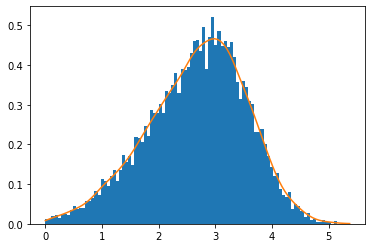

Histogram for F Test feature  1


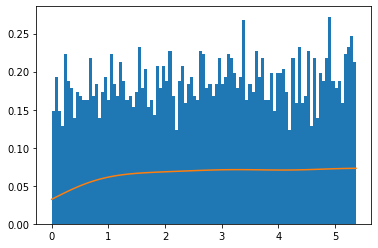

Histogram for F Test feature  2


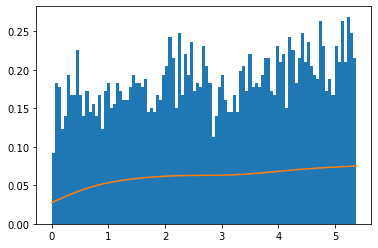

Histogram for F Test feature  3


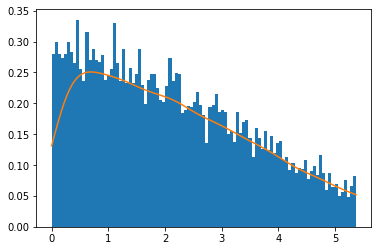

Histogram for F Test feature  4


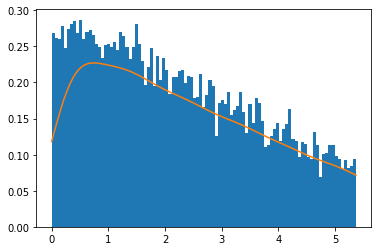

Histogram for F Test feature  5


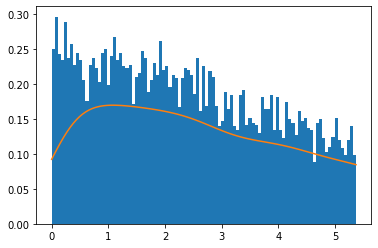

Histogram for F Test feature  6


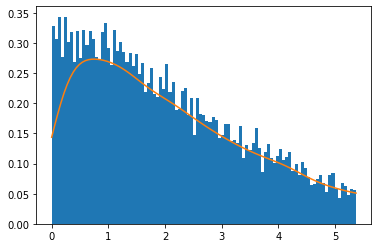

Histogram for F Test feature  7


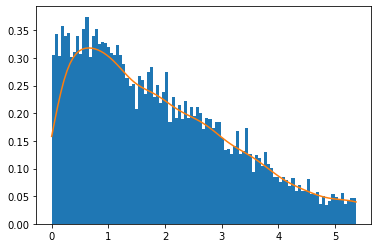

Histogram for F Test feature  8


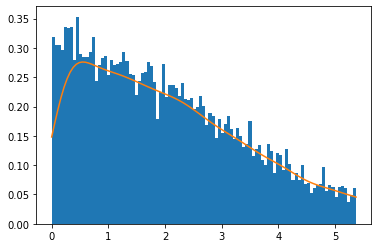

Histogram for F Test feature  9


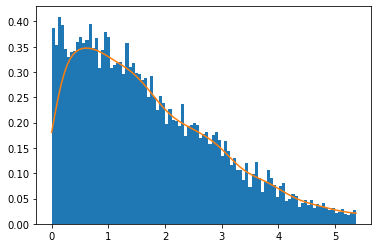

Histogram for F Test feature  10


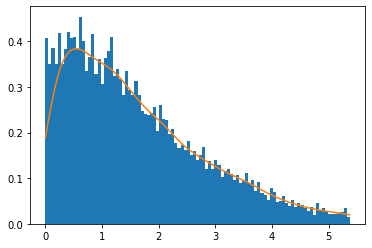

Histogram for F Test feature  11


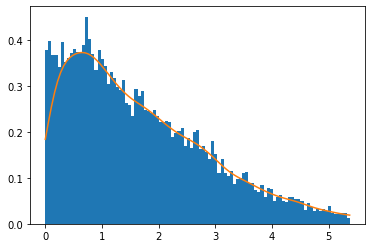

Histogram for F Test feature  12


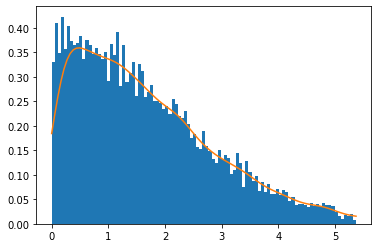

Histogram for F Test feature  13


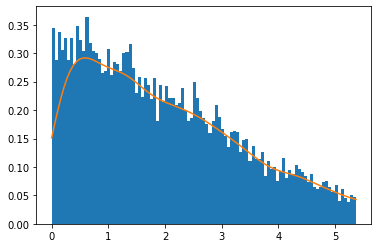

Histogram for F Test feature  14


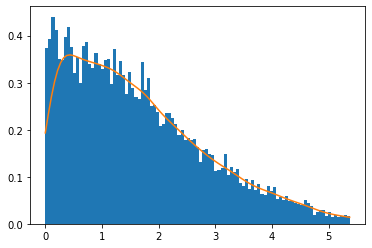

Histogram for F Test feature  15


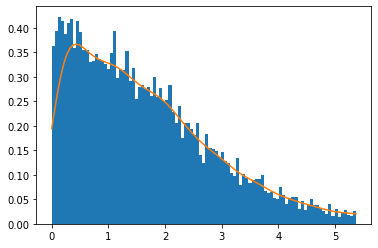

Histogram for F Test feature  16


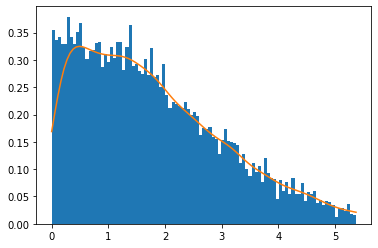

Histogram for F Test feature  17


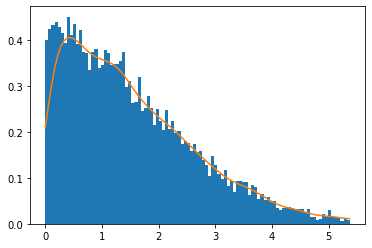

Histogram for F Test feature  18


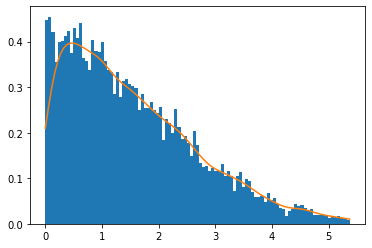

Histogram for F Test feature  19


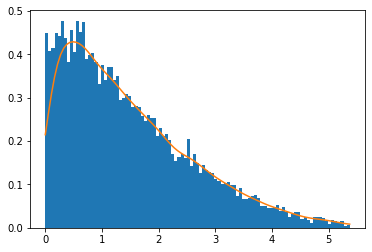

Histogram for F Test feature  20


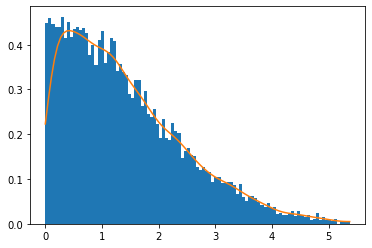

Histogram for F Test feature  21


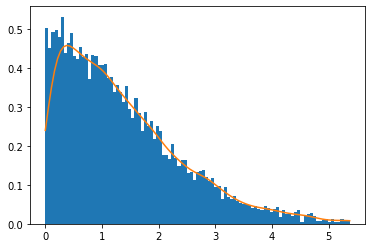

Histogram for F Test feature  22


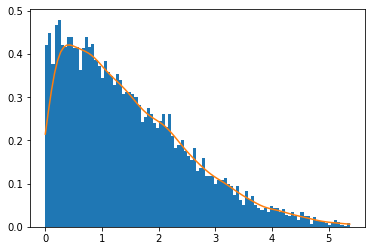

Histogram for F Test feature  23


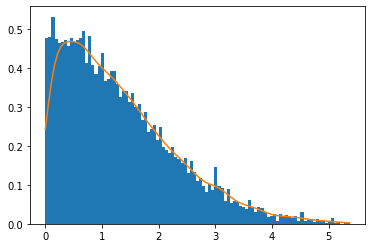

Histogram for F Test feature  24


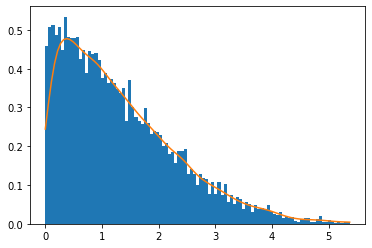

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5521
LR Accuracy on test data - All features:  0.3319
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5489
Logistic Regression Accuracy on test data - rotated:  0.3171
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5477
Logistic Regression Accuracy on test data - rotated:  0.3335
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5438
Logistic Regression Accuracy on test data - rotated:  0.3225
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5411
Logistic Regression Accuracy on test data - rotated:  0.2869
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5432
Logistic Regression Accuracy on test data - rotated:  0.2593
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5407
Logistic Regression Accuracy on test data - rotated:  0.3163
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5426
Logistic Regression Accuracy on test data - rotated:  0.3042
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5431
Logistic Regression Accuracy on test data - rotated:  0.3257
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5401
Logistic Regression Accuracy on test data - rotated:  0.3276
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5395
Logistic Regression Accuracy on test data - rotated:  0.3291
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5398
Logistic Regression Accuracy on test data - rotated:  0.2912
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5441
Logistic Regression Accuracy on test data - rotated:  0.3179
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5461
Logistic Regression Accuracy on test data - rotated:  0.3167
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5371
Logistic Regression Accuracy on test data - rotated:  0.3163
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5424
Logistic Regression Accuracy on test data - rotated:  0.3241
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.546
Logistic Regression Accuracy on test data - rotated:  0.3233
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.545
Logistic Regression Accuracy on test data - rotated:  0.315
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5456
Logistic Regression Accuracy on test data - rotated:  0.3301
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5418
Logistic Regression Accuracy on test data - rotated:  0.3102
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5456
Logistic Regression Accuracy on test data - rotated:  0.3324
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5483
Logistic Regression Accuracy on test data - rotated:  0.3352
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5442
Logistic Regression Accuracy on test data - rotated:  0.337
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5442
Logistic Regression Accuracy on test data - rotated:  0.3296
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5481
Logistic Regression Accuracy on test data - rotated:  0.3188
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.546
Logistic Regression Accuracy on test data - rotated:  0.3266




Results for lamda  0.001

Printing eigenvalues
(512,)
[-2.62258919e+02 -4.28329327e+01 -2.10829066e+01 -2.02189492e+01
 -1.52682311e+01 -1.31319285e+01 -1.18210020e+01 -8.69005020e+00
 -7.92116524e+00 -6.75413916e+00 -6.26222953e+00 -5.48732485e+00
 -5.06248391e+00 -4.78395383e+00 -4.54074250e+00 -3.99029057e+00
 -3.31891018e+00 -3.28831127e+00 -2.81440417e+00 -2.78983716e+00
 -2.59544327e+00 -2.56647020e+00 -2.37156058e+00 -2.20107344e+00
 -2.10816116e+00 -2.06856323e+00 -1.98898189e+00 -1.81816217e+00
 -1.79040918e+00 -1.60202834e+00 -1.52148076e+00 -1.46549253e+00
 -1.40808318e+00 -1.29391355e+00 -1.25358093e+00 -1.22175059e+00
 -1.16280502e+00 -1.13028715e+00 -1.10151164e+00 -1.04990199e+00
 -1.01062685e+00 -9.56630927e-01 -9.54375527e-01 -8.99974716e-01
 -8.76147641e-01 -8.52423023e-01 -8.19726068e-01 -8.18031325e-01
 -7.80256336e-01 -7.43295382e

(512, 512)

array([[-4.57514997e-02,  3.01579107e-02, -1.82152713e-03, ...,
         6.08717674e-03, -1.51616326e-03,  5.30513662e-02],
       [-1.20326348e-01,  9.05644933e-02, -1.46646636e-01, ...,
         3.99569699e-04,  1.03662099e-03,  9.86060436e-03],
       [-7.77326433e-02,  8.66407019e-02, -8.54429127e-02, ...,
         3.02180547e-03,  5.51553569e-04, -2.56525486e-02],
       ...,
       [-2.56458872e-02, -2.58908171e-02,  9.13360570e-03, ...,
         1.93565660e-03, -1.01861450e-03,  7.37840142e-03],
       [-1.62424247e-02, -2.91693787e-02,  2.20477112e-02, ...,
         1.15683397e-02,  7.25650615e-05, -4.95922804e-02],
       [-6.23946093e-03, -6.90240158e-03,  1.26614251e-02, ...,
        -1.23107793e-02, -1.60148995e-02,  1.84949439e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[-262.25891908  -42.83293268  -21.08290655  -20.21894918  -15.26823112
  -13.13192848  -11.821002     -8.6900502    -7.92116524   -6.75413916
   -6.26222953   -5.48732485   -5.06248391   -4.78395383   -4.5407425
   -3.99029057   -3.31891018   -3.28831127   -2.81440417   -2.78983716
   -2.59544327   -2.5664702    -2.37156058   -2.20107344   -2.10816116]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-262.25891908  -42.83293268  -21.08290655  -20.21894918  -15.26823112
  -13.13192848  -11.821002     -8.6900502    -7.92116524   -6.75413916
   -6.26222953   -5.48732485   -5.06248391   -4.78395383   -4.5407425
   -3.99029057   -3.31891018   -3.28831127   -2.81440417   -2.78983716
   -2.59544327   -2.5664702    -2.37156058   -2.20107344]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,10.956721,7.812338,2.133837,5.347513,3.836888,2.157683,1.821091,2.121607,3.389290,...,0.043527,1.385844,0.366390,1.632999,0.754131,1.011969,0.612719,1.512584,0.244220,0.706130
1,2.435494,5.432981,3.312223,2.897926,5.297502,3.668694,7.179493,5.003339,8.483694,2.220404,...,1.287891,0.191376,1.829515,4.475979,0.498165,1.403144,0.849330,1.709596,2.067691,0.638959
2,3.148465,4.923709,2.638088,7.903117,6.742637,8.404665,6.853527,6.627814,0.876593,0.538008,...,0.162752,2.193054,0.450178,1.362385,0.279325,0.076572,2.381588,0.376756,1.695300,2.554987
3,3.554349,12.263337,10.925453,1.464977,5.936812,4.462590,4.599309,2.460210,3.587483,2.870148,...,0.524112,1.034920,1.114052,1.251502,3.484795,0.685038,0.714558,2.117151,0.021256,0.270644
4,2.496241,7.507963,4.026366,3.062144,2.485316,3.910016,2.129945,0.547427,0.195358,0.064939,...,4.966008,3.041041,0.693112,3.580106,2.832779,0.962704,0.840011,1.255080,1.197376,1.363627


Histogram for F Test feature  0


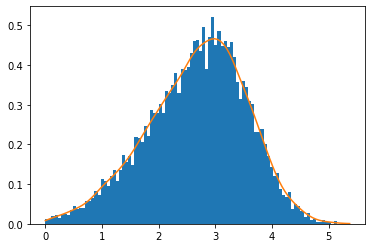

Histogram for F Test feature  1


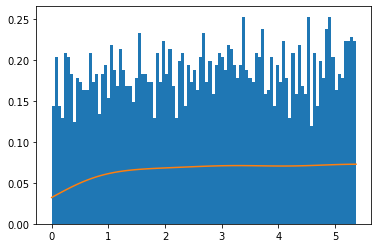

Histogram for F Test feature  2


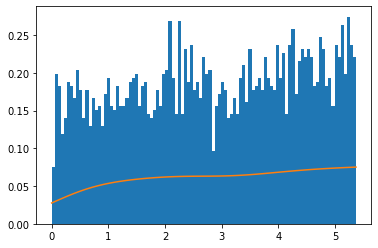

Histogram for F Test feature  3


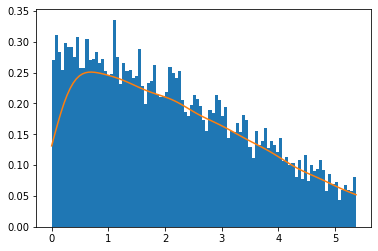

Histogram for F Test feature  4


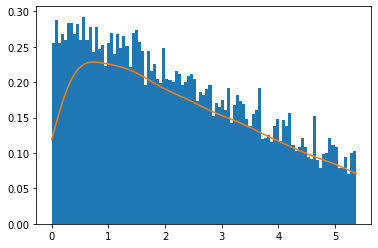

Histogram for F Test feature  5


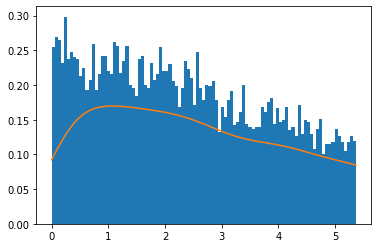

Histogram for F Test feature  6


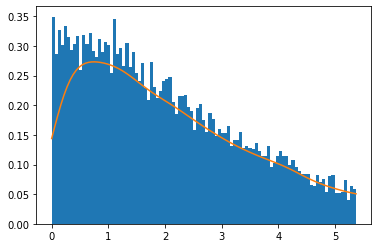

Histogram for F Test feature  7


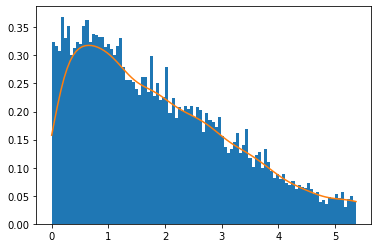

Histogram for F Test feature  8


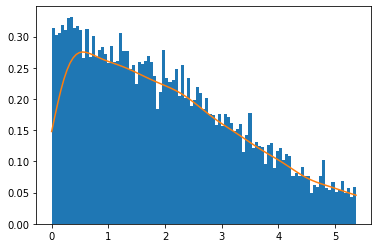

Histogram for F Test feature  9


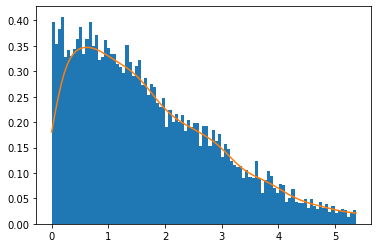

Histogram for F Test feature  10


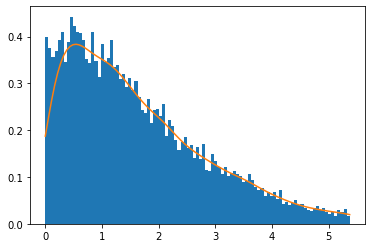

Histogram for F Test feature  11


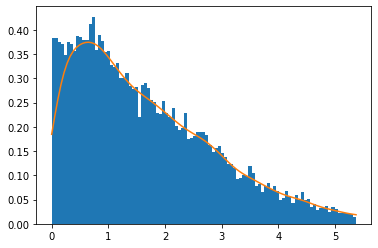

Histogram for F Test feature  12


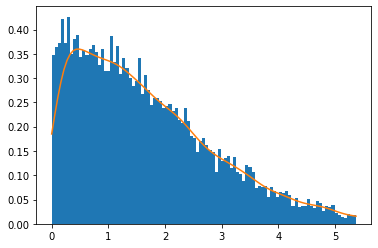

Histogram for F Test feature  13


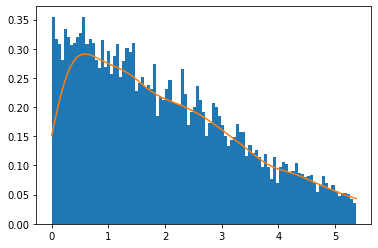

Histogram for F Test feature  14


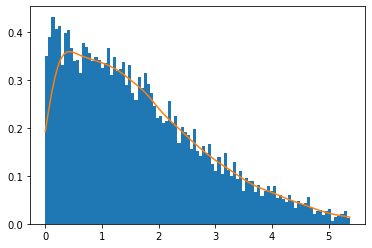

Histogram for F Test feature  15


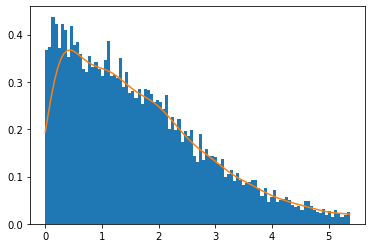

Histogram for F Test feature  16


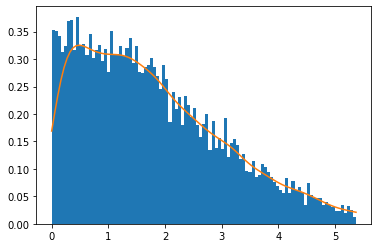

Histogram for F Test feature  17


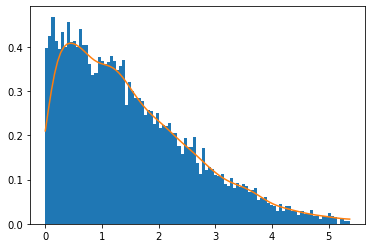

Histogram for F Test feature  18


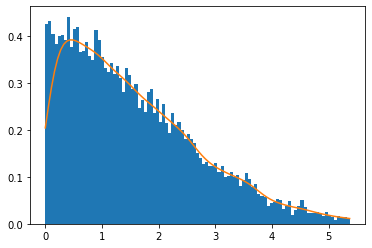

Histogram for F Test feature  19


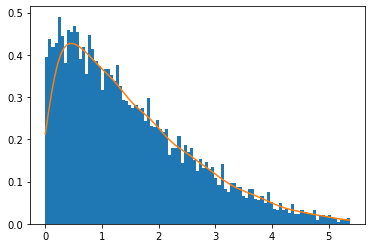

Histogram for F Test feature  20


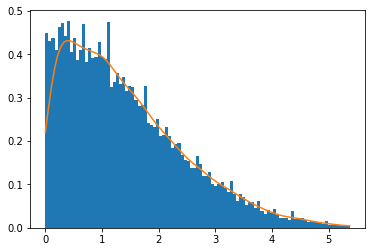

Histogram for F Test feature  21


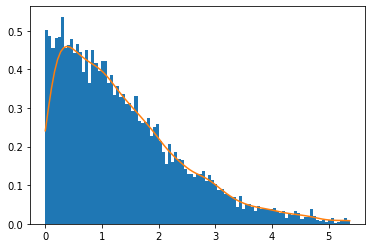

Histogram for F Test feature  22


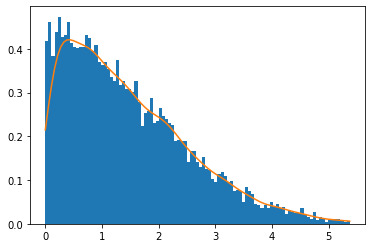

Histogram for F Test feature  23


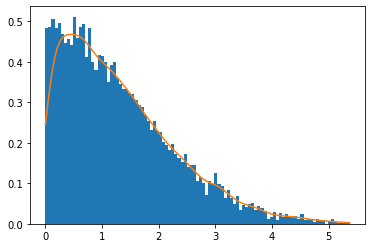

Histogram for F Test feature  24


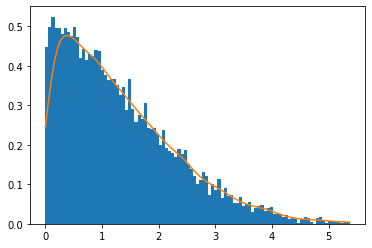

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.551
LR Accuracy on test data - All features:  0.3323
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5489
Logistic Regression Accuracy on test data - rotated:  0.3193
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5469
Logistic Regression Accuracy on test data - rotated:  0.3356
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5438
Logistic Regression Accuracy on test data - rotated:  0.3225
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5404
Logistic Regression Accuracy on test data - rotated:  0.2843
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.543
Logistic Regression Accuracy on test data - rotated:  0.2586
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5409
Logistic Regression Accuracy on test data - rotated:  0.3189
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5428
Logistic Regression Accuracy on test data - rotated:  0.3046
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5423
Logistic Regression Accuracy on test data - rotated:  0.3277
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5392
Logistic Regression Accuracy on test data - rotated:  0.3273
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5398
Logistic Regression Accuracy on test data - rotated:  0.3282
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5396
Logistic Regression Accuracy on test data - rotated:  0.2914
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5438
Logistic Regression Accuracy on test data - rotated:  0.3186
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5463
Logistic Regression Accuracy on test data - rotated:  0.3162
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5373
Logistic Regression Accuracy on test data - rotated:  0.3159
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5427
Logistic Regression Accuracy on test data - rotated:  0.3243
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5468
Logistic Regression Accuracy on test data - rotated:  0.3244
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5446
Logistic Regression Accuracy on test data - rotated:  0.3131
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5457
Logistic Regression Accuracy on test data - rotated:  0.3311
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5408
Logistic Regression Accuracy on test data - rotated:  0.3105
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5457
Logistic Regression Accuracy on test data - rotated:  0.3308
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5484
Logistic Regression Accuracy on test data - rotated:  0.3342
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5439
Logistic Regression Accuracy on test data - rotated:  0.3364
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5441
Logistic Regression Accuracy on test data - rotated:  0.3311
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5486
Logistic Regression Accuracy on test data - rotated:  0.3173
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5456
Logistic Regression Accuracy on test data - rotated:  0.3274




Results for lamda  0.0001

Printing eigenvalues
(512,)
[-2.62454747e+02 -4.28447718e+01 -2.10889920e+01 -2.02249072e+01
 -1.52731042e+01 -1.31373568e+01 -1.18243565e+01 -8.69290073e+00
 -7.92377661e+00 -6.75609015e+00 -6.26473080e+00 -5.48948079e+00
 -5.06462496e+00 -4.78582797e+00 -4.54220223e+00 -3.99192823e+00
 -3.32010280e+00 -3.28950889e+00 -2.81533850e+00 -2.79118142e+00
 -2.59636128e+00 -2.56757262e+00 -2.37242097e+00 -2.20205525e+00
 -2.10924680e+00 -2.06944911e+00 -1.98980445e+00 -1.81925742e+00
 -1.79120335e+00 -1.60278905e+00 -1.52217186e+00 -1.46618489e+00
 -1.40875579e+00 -1.29470391e+00 -1.25429734e+00 -1.22236037e+00
 -1.16342141e+00 -1.13105451e+00 -1.10220539e+00 -1.05067209e+00
 -1.01148505e+00 -9.57423272e-01 -9.54901888e-01 -9.00424970e-01
 -8.76784572e-01 -8.52902705e-01 -8.20228740e-01 -8.18628031e-01
 -7.80709805e-01 -7.4382797

(512, 512)

array([[-4.57580016e-02,  3.01588259e-02, -1.82920873e-03, ...,
         6.22170158e-03, -1.51374822e-03,  5.30513661e-02],
       [-1.20318375e-01,  9.05166052e-02, -1.46584238e-01, ...,
         3.58138531e-04,  1.02970034e-03,  9.86060432e-03],
       [-7.77609544e-02,  8.66532718e-02, -8.54758625e-02, ...,
         3.06984043e-03,  5.73682349e-04, -2.56525487e-02],
       ...,
       [-2.56503112e-02, -2.58865651e-02,  9.15072121e-03, ...,
         1.91895584e-03, -1.01906601e-03,  7.37840128e-03],
       [-1.62580647e-02, -2.91399898e-02,  2.20527457e-02, ...,
         1.15257527e-02,  8.31021159e-05, -4.95922806e-02],
       [-6.24185714e-03, -6.90398031e-03,  1.26687016e-02, ...,
        -1.22309082e-02, -1.59983814e-02,  1.84949440e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[-262.45474727  -42.84477178  -21.08899199  -20.22490715  -15.27310418
  -13.13735679  -11.82435645   -8.69290073   -7.92377661   -6.75609015
   -6.2647308    -5.48948079   -5.06462496   -4.78582797   -4.54220223
   -3.99192823   -3.3201028    -3.28950889   -2.8153385    -2.79118142
   -2.59636128   -2.56757262   -2.37242097   -2.20205525   -2.1092468 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-262.45474727  -42.84477178  -21.08899199  -20.22490715  -15.27310418
  -13.13735679  -11.82435645   -8.69290073   -7.92377661   -6.75609015
   -6.2647308    -5.48948079   -5.06462496   -4.78582797   -4.54220223
   -3.99192823   -3.3201028    -3.28950889   -2.8153385    -2.79118142
   -2.59636128   -2.56757262   -2.37242097   -2.20205525]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,10.958236,7.811770,2.135445,5.344832,3.837729,2.157854,1.819769,2.122466,3.388763,...,0.043820,1.383387,0.373176,1.630061,0.747481,1.019222,0.611991,1.513139,0.245164,0.704482
1,2.435494,5.434112,3.312207,2.896790,5.298637,3.661883,7.180080,5.005402,8.484564,2.218749,...,1.289513,0.191559,1.806069,4.484416,0.489021,1.409074,0.844900,1.709231,2.066231,0.640940
2,3.148465,4.924743,2.637546,7.901857,6.745216,8.400070,6.855865,6.629550,0.878612,0.536041,...,0.164019,2.193135,0.455264,1.360746,0.279514,0.079110,2.383183,0.372367,1.696227,2.555080
3,3.554349,12.265402,10.924954,1.466353,5.934293,4.459656,4.600229,2.461751,3.589253,2.868497,...,0.523268,1.037162,1.106173,1.258330,3.490393,0.661149,0.714453,2.116202,0.022451,0.271235
4,2.496241,7.508063,4.024971,3.060031,2.488608,3.909133,2.131599,0.546469,0.197577,0.066283,...,4.964935,3.038218,0.712916,3.577117,2.826222,0.984185,0.837565,1.253606,1.195574,1.363196


Histogram for F Test feature  0


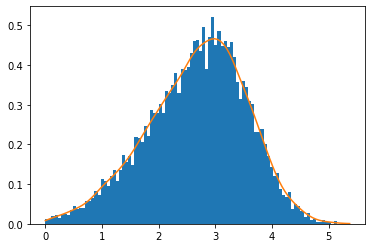

Histogram for F Test feature  1


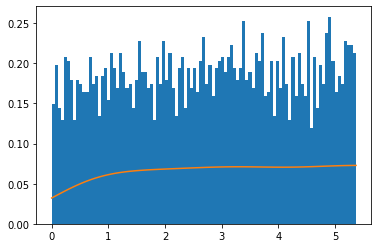

Histogram for F Test feature  2


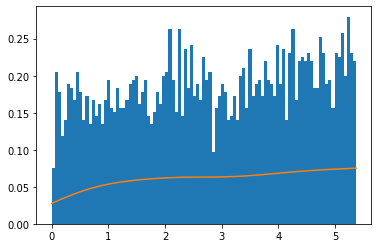

Histogram for F Test feature  3


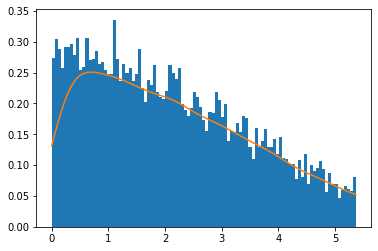

Histogram for F Test feature  4


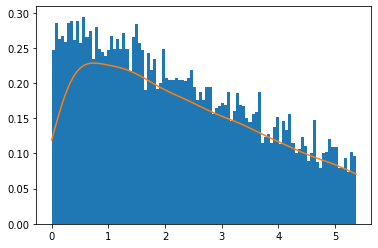

Histogram for F Test feature  5


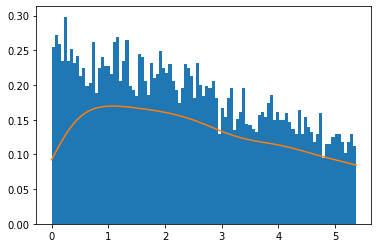

Histogram for F Test feature  6


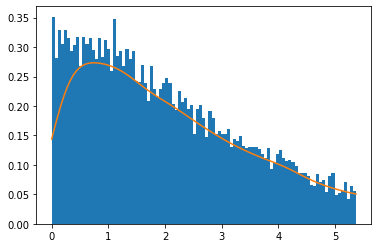

Histogram for F Test feature  7


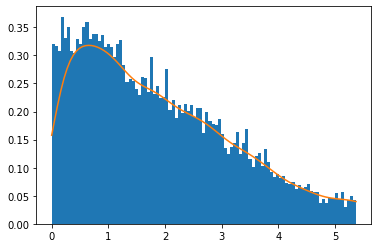

Histogram for F Test feature  8


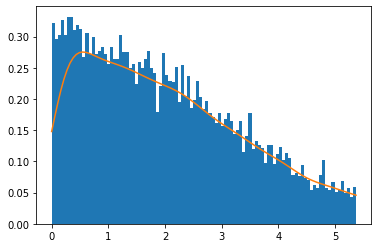

Histogram for F Test feature  9


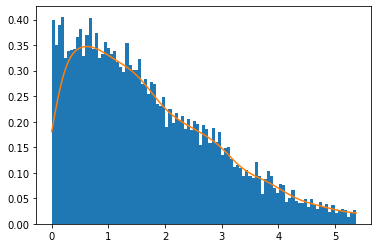

Histogram for F Test feature  10


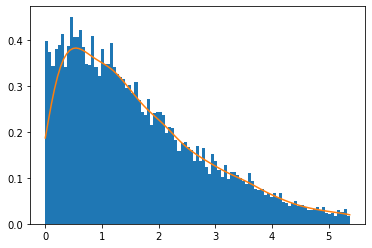

Histogram for F Test feature  11


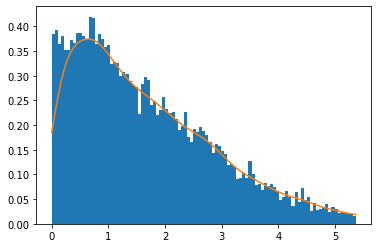

Histogram for F Test feature  12


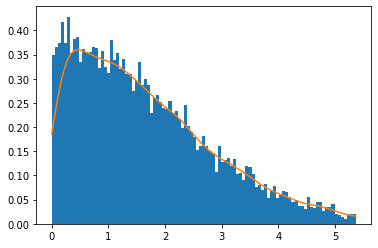

Histogram for F Test feature  13


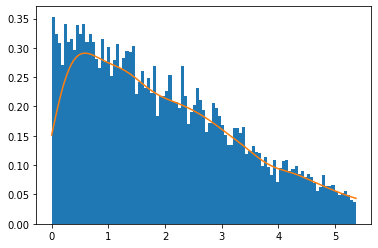

Histogram for F Test feature  14


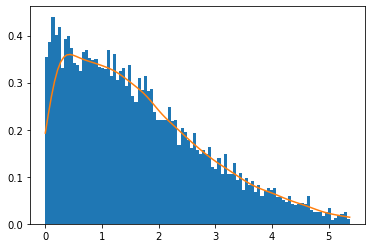

Histogram for F Test feature  15


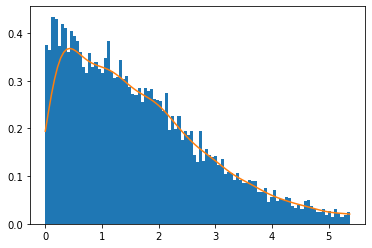

Histogram for F Test feature  16


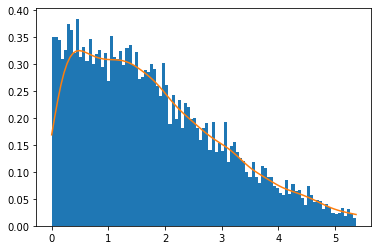

Histogram for F Test feature  17


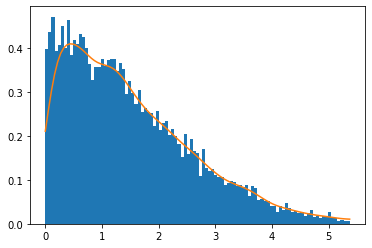

Histogram for F Test feature  18


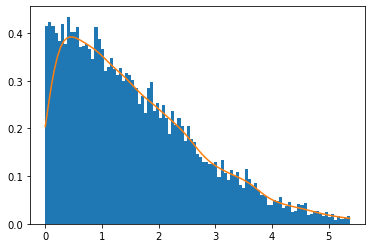

Histogram for F Test feature  19


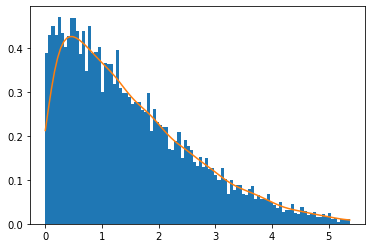

Histogram for F Test feature  20


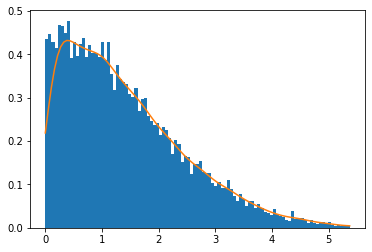

Histogram for F Test feature  21


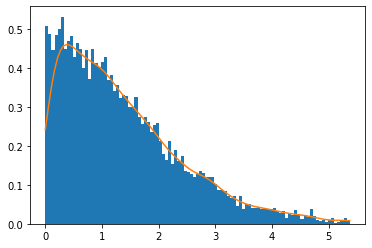

Histogram for F Test feature  22


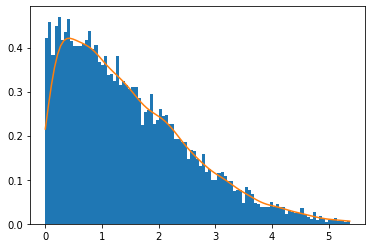

Histogram for F Test feature  23


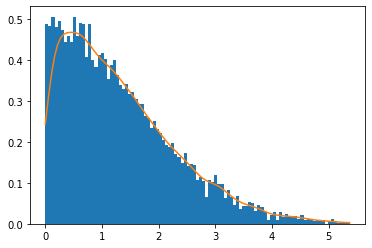

Histogram for F Test feature  24


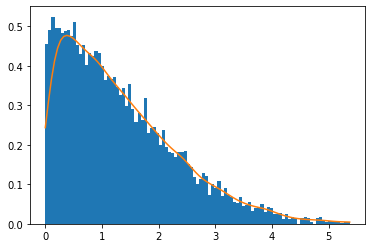

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5514
LR Accuracy on test data - All features:  0.3325
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5486
Logistic Regression Accuracy on test data - rotated:  0.3106
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5474
Logistic Regression Accuracy on test data - rotated:  0.3352
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5446
Logistic Regression Accuracy on test data - rotated:  0.3229
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5413
Logistic Regression Accuracy on test data - rotated:  0.281
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5427
Logistic Regression Accuracy on test data - rotated:  0.2601
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5401
Logistic Regression Accuracy on test data - rotated:  0.3181
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5423
Logistic Regression Accuracy on test data - rotated:  0.3045
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5436
Logistic Regression Accuracy on test data - rotated:  0.3259
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5397
Logistic Regression Accuracy on test data - rotated:  0.3284
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.539
Logistic Regression Accuracy on test data - rotated:  0.328
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5394
Logistic Regression Accuracy on test data - rotated:  0.2905
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5439
Logistic Regression Accuracy on test data - rotated:  0.3187
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5455
Logistic Regression Accuracy on test data - rotated:  0.3155
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5376
Logistic Regression Accuracy on test data - rotated:  0.3165
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5432
Logistic Regression Accuracy on test data - rotated:  0.3246
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5476
Logistic Regression Accuracy on test data - rotated:  0.3242
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5448
Logistic Regression Accuracy on test data - rotated:  0.3176
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5465
Logistic Regression Accuracy on test data - rotated:  0.3307
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5408
Logistic Regression Accuracy on test data - rotated:  0.3121
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5458
Logistic Regression Accuracy on test data - rotated:  0.3322
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5485
Logistic Regression Accuracy on test data - rotated:  0.3356
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5444
Logistic Regression Accuracy on test data - rotated:  0.3366
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.544
Logistic Regression Accuracy on test data - rotated:  0.3309
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5482
Logistic Regression Accuracy on test data - rotated:  0.3161
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5452
Logistic Regression Accuracy on test data - rotated:  0.3273




Results for lamda  1e-10

Printing eigenvalues
(512,)
[-2.62476508e+02 -4.28460872e+01 -2.10896682e+01 -2.02255692e+01
 -1.52736458e+01 -1.31379599e+01 -1.18247292e+01 -8.69321749e+00
 -7.92406683e+00 -6.75630704e+00 -6.26500871e+00 -5.48972051e+00
 -5.06486284e+00 -4.78603630e+00 -4.54236445e+00 -3.99211020e+00
 -3.32023545e+00 -3.28964189e+00 -2.81544248e+00 -2.79133072e+00
 -2.59646327e+00 -2.56769514e+00 -2.37251659e+00 -2.20216438e+00
 -2.10936769e+00 -2.06954752e+00 -1.98989587e+00 -1.81937916e+00
 -1.79129161e+00 -1.60287363e+00 -1.52224867e+00 -1.46626185e+00
 -1.40883055e+00 -1.29479196e+00 -1.25437700e+00 -1.22242817e+00
 -1.16348999e+00 -1.13114013e+00 -1.10228247e+00 -1.05075832e+00
 -1.01158058e+00 -9.57513041e-01 -9.54958838e-01 -9.00475021e-01
 -8.76855381e-01 -8.52956029e-01 -8.20284690e-01 -8.18694370e-01
 -7.80760188e-01 -7.43887523

(512, 512)

array([[-4.57587233e-02,  3.01589273e-02, -1.83006134e-03, ...,
         6.23580959e-03, -1.51356283e-03,  5.30513660e-02],
       [-1.20317489e-01,  9.05112869e-02, -1.46577303e-01, ...,
         3.53589908e-04,  1.02885957e-03,  9.86060432e-03],
       [-7.77640973e-02,  8.66546671e-02, -8.54795226e-02, ...,
         3.07383569e-03,  5.75799699e-04, -2.56525487e-02],
       ...,
       [-2.56508024e-02, -2.58860927e-02,  9.15262163e-03, ...,
         1.91754141e-03, -1.01901101e-03,  7.37840130e-03],
       [-1.62598013e-02, -2.91367256e-02,  2.20533033e-02, ...,
         1.15201514e-02,  8.40321895e-05, -4.95922806e-02],
       [-6.24212317e-03, -6.90415581e-03,  1.26695095e-02, ...,
        -1.22231287e-02, -1.59967748e-02,  1.84949439e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[-262.4765078   -42.84608716  -21.08966824  -20.22556919  -15.27364584
  -13.13795988  -11.82472919   -8.69321749   -7.92406683   -6.75630704
   -6.26500871   -5.48972051   -5.06486284   -4.7860363    -4.54236445
   -3.9921102    -3.32023545   -3.28964189   -2.81544248   -2.79133072
   -2.59646327   -2.56769514   -2.37251659   -2.20216438   -2.10936769]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-262.4765078   -42.84608716  -21.08966824  -20.22556919  -15.27364584
  -13.13795988  -11.82472919   -8.69321749   -7.92406683   -6.75630704
   -6.26500871   -5.48972051   -5.06486284   -4.7860363    -4.54236445
   -3.9921102    -3.32023545   -3.28964189   -2.81544248   -2.79133072
   -2.59646327   -2.56769514   -2.37251659   -2.20216438]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.014026,10.958404,7.811707,2.135623,5.344534,3.837822,2.157873,1.819622,2.122562,3.388704,...,0.043853,1.383114,0.373929,1.629732,0.746723,1.020036,0.611911,1.513200,0.245269,0.704298
1,2.435494,5.434237,3.312205,2.896664,5.298763,3.661126,7.180145,5.005631,8.484661,2.218565,...,1.289693,0.191580,1.803460,4.485346,0.487981,1.409736,0.844408,1.709189,2.066068,0.641162
2,3.148465,4.924857,2.637485,7.901717,6.745502,8.399560,6.856125,6.629743,0.878836,0.535822,...,0.164160,2.193144,0.455829,1.360562,0.279539,0.079388,2.383359,0.371878,1.696331,2.555090
3,3.554349,12.265631,10.924899,1.466506,5.934013,4.459330,4.600330,2.461922,3.589450,2.868313,...,0.523174,1.037411,1.105294,1.259086,3.491015,0.658439,0.714442,2.116096,0.022584,0.271301
4,2.496241,7.508074,4.024816,3.059796,2.488974,3.909034,2.131783,0.546363,0.197823,0.066432,...,4.964816,3.037904,0.715117,3.576777,2.825469,0.986610,0.837293,1.253441,1.195373,1.363147


Histogram for F Test feature  0


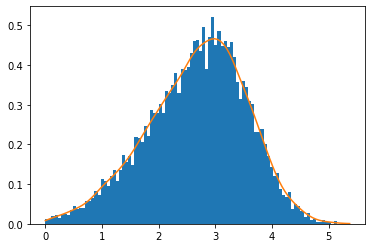

Histogram for F Test feature  1


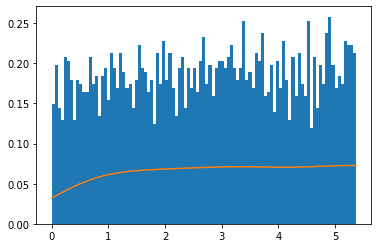

Histogram for F Test feature  2


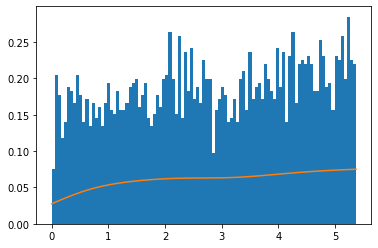

Histogram for F Test feature  3


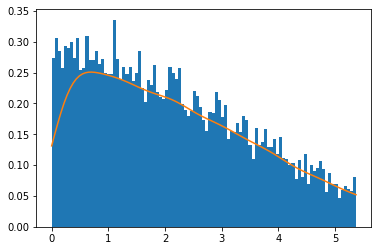

Histogram for F Test feature  4


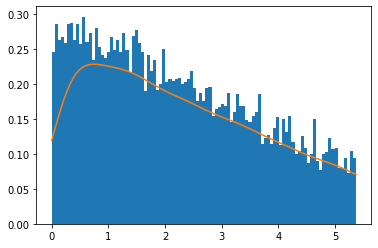

Histogram for F Test feature  5


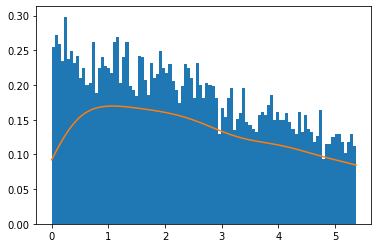

Histogram for F Test feature  6


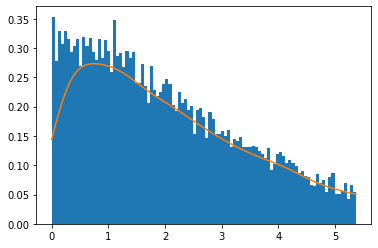

Histogram for F Test feature  7


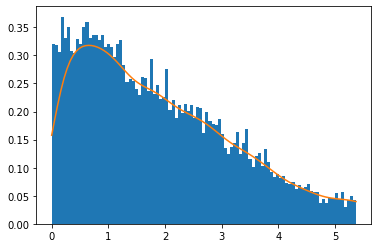

Histogram for F Test feature  8


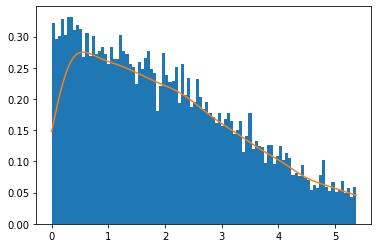

Histogram for F Test feature  9


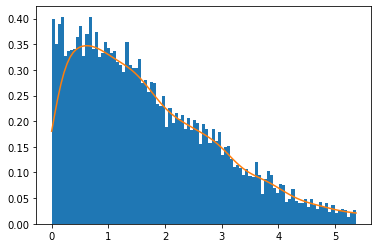

Histogram for F Test feature  10


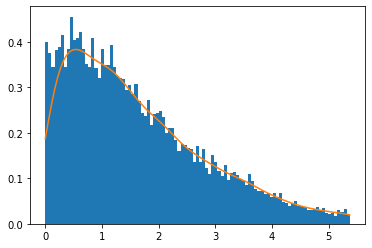

Histogram for F Test feature  11


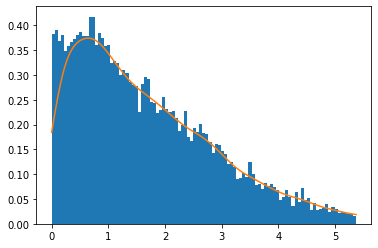

Histogram for F Test feature  12


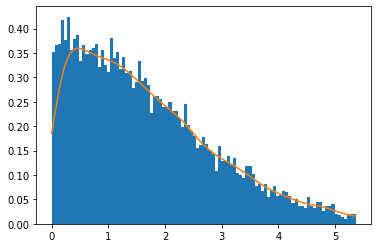

Histogram for F Test feature  13


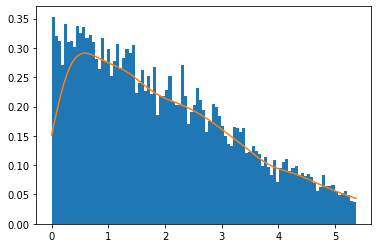

Histogram for F Test feature  14


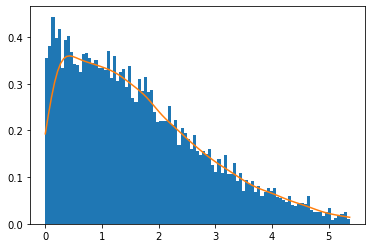

Histogram for F Test feature  15


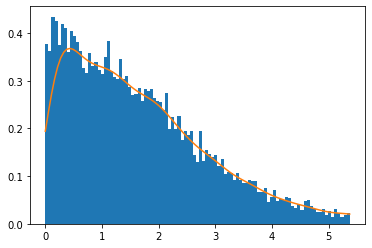

Histogram for F Test feature  16


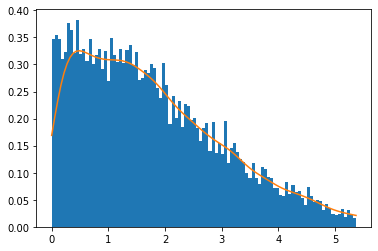

Histogram for F Test feature  17


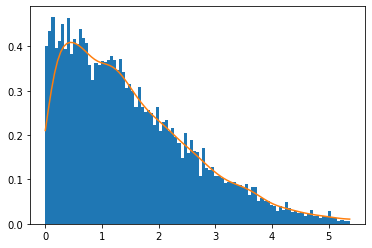

Histogram for F Test feature  18


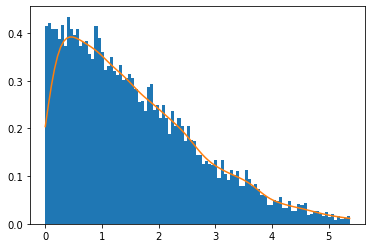

Histogram for F Test feature  19


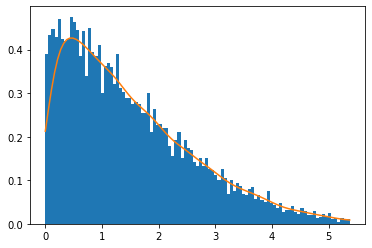

Histogram for F Test feature  20


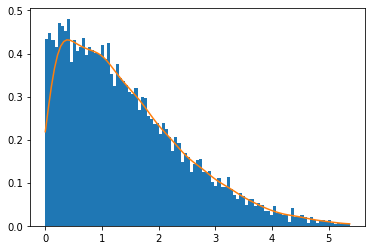

Histogram for F Test feature  21


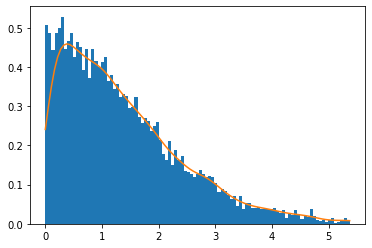

Histogram for F Test feature  22


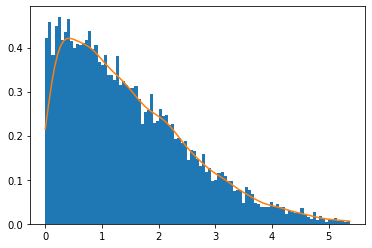

Histogram for F Test feature  23


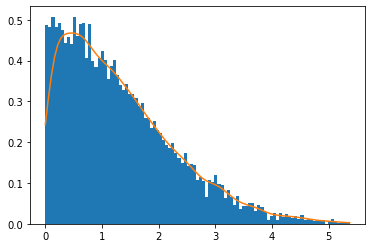

Histogram for F Test feature  24


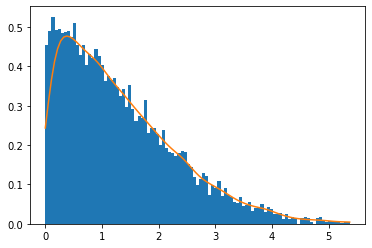

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5514
LR Accuracy on test data - All features:  0.3326
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5498
Logistic Regression Accuracy on test data - rotated:  0.3109
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5473
Logistic Regression Accuracy on test data - rotated:  0.3355
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5454
Logistic Regression Accuracy on test data - rotated:  0.3231
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5411
Logistic Regression Accuracy on test data - rotated:  0.2839
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.543
Logistic Regression Accuracy on test data - rotated:  0.2604
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5397
Logistic Regression Accuracy on test data - rotated:  0.3176
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5421
Logistic Regression Accuracy on test data - rotated:  0.3045
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5437
Logistic Regression Accuracy on test data - rotated:  0.3239
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5404
Logistic Regression Accuracy on test data - rotated:  0.3282
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5394
Logistic Regression Accuracy on test data - rotated:  0.3286
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5388
Logistic Regression Accuracy on test data - rotated:  0.2909
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5442
Logistic Regression Accuracy on test data - rotated:  0.3182
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5463
Logistic Regression Accuracy on test data - rotated:  0.3163
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5375
Logistic Regression Accuracy on test data - rotated:  0.3169
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5434
Logistic Regression Accuracy on test data - rotated:  0.3236
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5472
Logistic Regression Accuracy on test data - rotated:  0.3233
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5451
Logistic Regression Accuracy on test data - rotated:  0.3152
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5465
Logistic Regression Accuracy on test data - rotated:  0.331
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5398
Logistic Regression Accuracy on test data - rotated:  0.3117
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5461
Logistic Regression Accuracy on test data - rotated:  0.3304
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5487
Logistic Regression Accuracy on test data - rotated:  0.3342
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5449
Logistic Regression Accuracy on test data - rotated:  0.3366
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5432
Logistic Regression Accuracy on test data - rotated:  0.331
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not rotated:  0.5478
Logistic Regression Accuracy on test data - rotated:  0.3183
Accuracy for without feature  24
Logistic Regression Accuracy within training data - not rotated:  0.5462
Logistic Regression Accuracy on test data - rotated:  0.3275


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [100000,0.1,0.01,0.001,0.0001,0.0000000001]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.05) # % of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(train_rotation_labels)/2),:] - Z[int(len(train_rotation_labels)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = rotation_coefficients @ rotation_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    print("Printing eigenvalues")
    print(eigenvalues.shape)
    print(eigenvalues)
    print("Printing eigenvectors")
    display(eigenvectors.shape)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = rotation_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_rotated = torch.from_numpy(np.linalg.lstsq(L, Z_test_rotated.transpose(), rcond=None)[0].transpose())



    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_rotated.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Trained on original images, tested on rotated images: all Features in F_test
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    X_torch_train = F_test_original
    X_torch_test = F_test_rotated
    X_torch_test_within = F_test_original

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)


    logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train.detach().numpy(), targets_train)

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_test_within))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_test))

    
    


    # Trained on original images, tested on rotated images: Rotation Features removed from F_test

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)

    for i in range(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_test_original.detach().numpy().copy()
        X_torch_test = F_test_rotated.detach().numpy().copy()
        X_torch_test_within = F_test_original.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train, targets_train)

        print('Logistic Regression Accuracy within training data - not rotated: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
        print('Logistic Regression Accuracy on test data - rotated: ', logistic_regression_model.score(X_torch_test, targets_test))




